<a href="https://colab.research.google.com/github/jo1jun/Image-Captioning-with-Transformer/blob/main/Image_Captioning_Attention_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [252]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.datasets as dset
import torch.utils.data as data
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

# tensorboard writer
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

# tensor 연산을 간편하게 하기 위해 einops moudule import.
# reference & tutorial : http://einops.rocks/pytorch-examples.html
%pip install einops
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange

# WarmupCosineSchedule 이용
% pip install pytorch_transformers
from pytorch_transformers.optimization import WarmupCosineSchedule

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# COCO dataset

In [253]:
import collections
import random
import time
import json
from PIL import Image

with open('./dataset/COCO/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

PATH = './dataset/COCO/train2014/'

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = val['caption']
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [254]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths
print(len(train_image_paths))

82783


In [255]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [256]:
print(len(train_captions))
print(len(img_name_vector))

414113
414113


# Caption Preprocessing

In [257]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [258]:
import nltk
nltk.download('punkt')
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO

threshold = 100

counter = Counter()
for i, caption in enumerate(train_captions):
  tokens = nltk.tokenize.word_tokenize(caption)
  counter.update(tokens)

  if (i+1) % 100000 == 0:
    print("[{}/{}] Tokenized the captions.".format(i+1, len(train_captions)))

words = [word for word, cnt in counter.items() if cnt >= threshold]

vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

# Add the words to the vocabulary.
for i, word in enumerate(words):
  vocab.add_word(word)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[100000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[300000/414113] Tokenized the captions.
[400000/414113] Tokenized the captions.


In [259]:
captions = []
for caption in train_captions:
  # Convert caption (string) to word ids.
  tokens = nltk.tokenize.word_tokenize(str(caption).lower())
  caption = []
  caption.append(vocab('<start>'))
  caption.extend([vocab(token) for token in tokens])
  caption.append(vocab('<end>'))
  target = torch.Tensor(caption)
  captions.append(target)

In [260]:
# 모든 caption 중 최대 길이

max_len = 0
for cap in captions:
  if max_len < len(cap):
    max_len = len(cap)

print(max_len)

59


In [261]:
# id 화 된 caption sample

lengths = [len(cap) for cap in captions]
targets = torch.zeros(len(captions), max_len).long()
for i, cap in enumerate(captions):
  end = lengths[i]
  targets[i, :end] = cap[:end]   


print(targets[0])

tensor([ 1,  7,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  5, 10, 15, 16, 17, 18,
        19,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0])


In [262]:
# 데이터가 너무 크므로 1000개의 caption 을 추출하여 training.

targets = targets[:1000]

# Dataset

In [263]:
class CocoDataset(data.Dataset):
  def __init__(self, img_name_vector, targets, transform):
    self.img_name_vector = img_name_vector
    self.targets = targets
    self.transform = transform

  def __getitem__(self, index):
    """Returns one data pair (image and caption)."""

    image = Image.open(img_name_vector[index]).convert("RGB")
    if self.transform is not None:
      image = self.transform(image)

    target = targets[index]

    return image, target

  def __len__(self):
    return len(self.targets)

In [264]:
transform = T.Compose([
        T.ToTensor(), 
        T.Resize((224,224)),
        T.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

coco = CocoDataset(img_name_vector, targets, transform=transform)

# ViT

In [265]:
%pip install transformers

from transformers import ViTModel, ViTConfig

# Token & Positional Embedding

In [266]:
class TokPosEmbedding(nn.Module):
  def __init__(self, input_dim, d_model, dropout_ratio):
    super().__init__()
    # input_dim : input 의 vocab 수.
    self.tokEmbedding = nn.Embedding(input_dim, d_model)
    self.posEmbedding = nn.Embedding(100, d_model) # cos & sin positional encoding 대신, learnable positional embedding 으로 구현. (max length = 100)
                                                   # max length : 입력 sequence 의 최대 길이.
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, src):
    batch_size = src.shape[0]
    src_len = src.shape[1]

    # 0 ~ src_len 등차 수열값 을 bactch 한개와 동일한 shape으로 생성 (positional embedding)
    pos = torch.arange(0, src_len, dtype=dtype) # pos: [src_len]
    pos = repeat(pos, 'l -> b l', b=batch_size).to(device) # pos: [batch_size, src_len]

    src = self.dropout((self.tokEmbedding(src) * np.sqrt(self.d_model)) + self.posEmbedding(pos))

    # src: [batch_size, src_len, d_model]

    return src

# Position Wise Feed Forward Layer

In [267]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, d_model, ff_dim, dropout_ratio):
        super().__init__()
        # ff_dim : FFN 에서 hidden layer node 수
        self.linear1 = nn.Linear(d_model, ff_dim)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.linear1(x)))

        # x: [batch_size, seq_len, ff_dim]

        x = self.linear2(x)

        # x: [batch_size, seq_len, d_model]

        return x

# Multi Head Attention Layer

In [268]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout_ratio):
        super().__init__()

        self.d_model = d_model # d_model : embed dimension
        self.nhead = nhead # nhead : head 수
        self.head_dim = d_model // nhead # head_dim : head 마다의 dimension

        # 위 figure 에서 Q, K, V 가 head 수 만큼의 Linear 를 거쳐 Scaled Dot-Product Attention에 들어가는데
        # 실제 구현에서는 Q, K, V 각각이 하나의 Linear 를 거쳐 나온 것을 쪼개서 Scaled Dot-Product Attention에 들어가게 함.
        self.qLinear = nn.Linear(d_model, d_model) # query lineqr
        self.kLinear = nn.Linear(d_model, d_model) # key linear
        self.vLinear = nn.Linear(d_model, d_model) # value linear

        self.oLinear = nn.Linear(d_model, d_model) # output linear

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]
        query_len = query.shape[1]
        value_len = key_len = key.shape[1]

        # query: [batch_size, query_len, d_model]
        # key: [batch_size, key_len, d_model]
        # value: [batch_size, value_len, d_model]
 
        Q = self.qLinear(query)
        K = self.kLinear(key)
        V = self.vLinear(value)

        # Q: [batch_size, query_len, d_model]
        # K: [batch_size, key_len, d_model]
        # V: [batch_size, value_len, d_model]

        # d_model = nhead * head_dim
        # head 수로 distribute
        Q = rearrange(Q, 'b l (h d) -> b h l d', h=self.nhead)
        K = rearrange(K, 'b l (h d) -> b h l d', h=self.nhead)
        V = rearrange(V, 'b l (h d) -> b h l d', h=self.nhead)

        # Q: [batch_size, nhead, query_len, head_dim]
        # K: [batch_size, nhead, key_len, head_dim]
        # V: [batch_size, nhead, value_len, head_dim]

        #=========Scaled Dot-Product Attention=========

        # attention 계산
        attention = torch.matmul(Q, rearrange(K, 'b h l d -> b h d l')) / np.sqrt(self.head_dim)

        # attention: [batch_size, nhead, query_len, key_len]

        if mask is not None:
            # mask 가 true 면 -1e9로 하여 softmax 값 0으로.
            attention = attention.masked_fill(mask, -1e9)

        attention = torch.softmax(attention, dim=-1)

        # attention: [batch_size, nhead, query_len, key_len]

        # context vector 계산
        c = torch.matmul(self.dropout(attention), V)

        # c: [batch_size, nhead, query_len, head_dim]

        #=========Scaled Dot-Product Attention=========

        # reshape & concat
        c = rearrange(c, 'b h l d -> b l (h d)')

        # c: [batch_size, query_len, d_model]

        output = self.oLinear(c)

        # output: [batch_size, query_len, d_model]

        return output, attention

# Decoder Layer

In [269]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.layerNorm3 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer1 = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.multiHeadAttentionLayer2= MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, tgt, enc_src, tgt_mask, src_mask):

        # tgt: [batch_size, tgt_len, d_model] # decoder 에 입력되는 값.
        # enc_src: [batch_size, src_len, d_model] # encoder의 출력값.
        # tgt_mask: [batch_size, tgt_len] # tgt 에 적용되는 mask (chitting 방지 mask)
        # src_mask: [batch_size, src_len]

        # self attention
        _tgt, _ = self.multiHeadAttentionLayer1(tgt, tgt, tgt, tgt_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm1(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]

        # encoder attention
        # decoder 의 query, encdoer 의 key, value 로 attention
        _tgt, attention = self.multiHeadAttentionLayer2(tgt, enc_src, enc_src, src_mask)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm2(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]

        # positionwise feedforward
        _tgt = self.positionWiseFeedForward(tgt)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        tgt = self.layerNorm3(tgt + self.dropout(_tgt))

        # tgt: [batch_size, tgt_len, d_model]
        # attention: [batch_size, nhead, tgt_len, src_len]

        return tgt, attention

# Decoder

In [270]:
class Decoder(nn.Module):
    def __init__(self, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()
        # n_layers : decoder layer 반복 수
        # Decoder Layer 을 n_layers 만큼 반복.
        self.layers = nn.ModuleList([DecoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

    def forward(self, tgt, enc_src, tgt_mask, src_mask):

        # tgt: [batch_size, tgt_len]
        # enc_src: [batch_size, src_len, d_model]
        # tgt_mask: [batch_size, tgt_len]
        # src_mask: [batch_size, src_len]

        batch_size = tgt.shape[0]
        tgt_len = tgt.shape[1]

        # tgt: [batch_size, tgt_len, d_model]

        for layer in self.layers:
            tgt, attention = layer(tgt, enc_src, tgt_mask, src_mask)

        # tgt: [batch_size, tgt_len, d_model]
        # attention: [batch_size, nhead, tgt_len, src_len]

        return tgt, attention

# Transformer

In [271]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', output_attentions=True)

        self.project = nn.Linear(input_dim, d_model)

        self.decEmbedding = TokPosEmbedding(output_dim, d_model, dropout_ratio)               # 외부에서 embedding
        self.decoderLayer =DecoderLayer(d_model, nhead, ff_dim, dropout_ratio)
        self.decoder = Decoder(d_model, n_layers, nhead, ff_dim, dropout_ratio)
        self.linear = nn.Linear(d_model, output_dim)                                          # 외부에서 마지막 fc-layer

    def make_src_mask(self, src, pad):

        # src: [batch_size, src_len]

        # pad mask
        src_mask = (src.data.eq(pad)).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]
        return src_mask

    def make_tgt_mask(self, tgt, pad):
        
        # tgt: [batch_size, tgt_len]

        tgt_pad_mask = (tgt.data.eq(pad)).unsqueeze(1).unsqueeze(2)

        # tgt_pad_mask: [batch_size, 1, 1, tgt_len]

        tgt_len = tgt.shape[1]

        # chitting 방지 mask
        tgt_sub_mask = torch.triu(torch.ones((tgt_len, tgt_len))).bool().to(device)

        # tgt_sub_mask: [tgt_len, tgt_len] (upper triangular square matrix 형태)

        # mask 값이 true 면 fill 할 것이므로 pad_mask 와 or 연산.
        tgt_mask = tgt_pad_mask | tgt_sub_mask

        # tgt_mask: [batch_size, 1, tgt_len, tgt_len]

        return tgt_mask

    def forward(self, src, tgt, pad):

        # src : 이미지 소스 : [batch_size, channel, w, h]

        src = self.vit(src)

        src = self.project(src.last_hidden_state[:, 1:, :])

        # tgt: [batch_size, tgt_len]

        tgt_mask = self.make_tgt_mask(tgt, pad)

        # tgt_mask: [batch_size, 1, tgt_len, tgt_len]

        tgt = self.decEmbedding(tgt)

        # enc_src: [batch_size, src_len, d_model]

        tgt, attention = self.decoder(tgt, src, tgt_mask, None)

        # tgt: [batch_size, tgt_len, d_model]
        # attention: [batch_size, nhead, tgt_len, src_len]

        output = self.linear(tgt)

        # output: [batch_size, tgt_len, output_dim]

        return output

    def generate(self, src, start_id, sample_size, pad):

        # src : 이미지 소스 : [batch_size, path 개수, 768]
        batch_size = src.shape[0]

        src = self.vit(src)

        attentions = src.attentions

        src = self.project(src.last_hidden_state[:, 1:, :])
      
        sampled_tensor = torch.tensor([start_id], dtype=dtype)
        # sampled_tensor: [1]

        sampled_tensor = repeat(sampled_tensor, 's -> b s', b=batch_size).to(device)
        # sampled_tensor: [batch_size, 1]
        for _ in range(sample_size):

          tgt_mask = self.make_tgt_mask(sampled_tensor, pad)
          tgt = self.decEmbedding(sampled_tensor)
          
          output, attention = self.decoder(tgt, src, tgt_mask, None)
          output = self.linear(output)

          pred_token = output.argmax(2)[:,-1].unsqueeze(1)

          sampled_tensor = torch.cat((sampled_tensor, pred_token), 1) # pred sentence 에 concat

        return sampled_tensor, attention, attentions

# HyperParameter (Overfitting)

In [277]:
print('vocab size : ', len(vocab))

batch_size = 64
num_epochs = 100
patch_dim = 768
vocab_size = len(vocab)
d_model = 512
n_layers = 2
nhead = 4
ff_dim = 2048
dropout_ratio = 0.1
learning_rate = 0.001

pad = 0
start = 1

model = Transformer(patch_dim, vocab_size, d_model, n_layers, nhead, ff_dim, dropout_ratio)
optimizer = optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

vocab size :  2031


# DataLoader

In [278]:
data_loader = DataLoader(coco, batch_size=batch_size, shuffle=True)

# Trainer

In [279]:
def trainer(model, criterion, optimizer, num_epochs, pad):

    pad = torch.tensor([pad], dtype=dtype).to(device)

    model = model.to(device)
    running_loss = {}

    for e in range(num_epochs):

        print('Epoch {}/{}'.format(e, num_epochs))
        print('-' * 10)

        for phase in ['train']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss[phase] = 0.0

          for iter, (images, captions) in enumerate(data_loader):

              images = images.to(device)
              captions = captions.to(device)

              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                scores = model(images, captions[:, :-1], pad) # correct 값의 마지막 원소 배제 (end token 없음. 마지막 원소 다음 token 학습할 필요 x)
                # scores: [batch_size, tgt_len - 1, output_dim]
                scores = rearrange(scores, 'b l d -> (b l) d')
                # captions: [batch_size, tgt_len]
              
                # correct 값의 첫 원소 배제
                captions = rearrange(captions[:, 1:], 'b l -> (b l)')

                # scores  : [batch_size * tgt_len - 1, output_dim]
                # captions : [batch_size * tgt_len - 1]

                loss = criterion(scores, captions)

                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  #torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0) # gradient clippling
                  optimizer.step()

              running_loss[phase] += loss.item() * batch_size

          running_loss[phase] = running_loss[phase] / (len(data_loader) * batch_size)

          print('{} Loss: {:.4f}'.format(phase, running_loss[phase]))

    return model

# Train

In [281]:
model = trainer(model, criterion, optimizer, num_epochs, pad)

Epoch 0/100
----------
train Loss: 1.7980
Epoch 1/100
----------
train Loss: 0.9845
Epoch 2/100
----------
train Loss: 0.9028
Epoch 3/100
----------
train Loss: 0.8436
Epoch 4/100
----------
train Loss: 0.7899
Epoch 5/100
----------
train Loss: 0.7469
Epoch 6/100
----------
train Loss: 0.7107
Epoch 7/100
----------
train Loss: 0.6750
Epoch 8/100
----------
train Loss: 0.6452
Epoch 9/100
----------
train Loss: 0.6178
Epoch 10/100
----------
train Loss: 0.5886
Epoch 11/100
----------
train Loss: 0.5649
Epoch 12/100
----------
train Loss: 0.5392
Epoch 13/100
----------
train Loss: 0.5154
Epoch 14/100
----------
train Loss: 0.4942
Epoch 15/100
----------
train Loss: 0.4685
Epoch 16/100
----------
train Loss: 0.4442
Epoch 17/100
----------
train Loss: 0.4230
Epoch 18/100
----------
train Loss: 0.4028
Epoch 19/100
----------
train Loss: 0.3837
Epoch 20/100
----------
train Loss: 0.3685
Epoch 21/100
----------
train Loss: 0.3454
Epoch 22/100
----------
train Loss: 0.3294
Epoch 23/100
--------

# Generating Caption & Visualizing Attention

A person is in mid air on a snowboard.
tensor([  1,   7, 118,  10,   6, 490,  53,  37,   7, 423,  19,   2,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0])


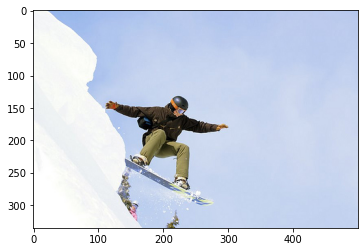

In [567]:
idx = random.choice(range(1000))

image = torch.FloatTensor(coco[idx][0]).to(device)
print(train_captions[idx])
print(targets[idx])
plt.imshow(Image.open(img_name_vector[idx]))

In [568]:
start = torch.tensor([start], dtype=dtype).to(device)
pad = torch.tensor([pad], dtype=dtype).to(device)
model = model.to(device)
with torch.no_grad():
  sample , att1, att2 = model.generate(image.unsqueeze(0), start_id=start, sample_size=max_len, pad = pad)

In [569]:
print(att1.shape) # [1, 4, 59, 196] : [batch_size, num_head, caption_len, num_patch]

attention = att1.squeeze(0).cpu().detach() # [1, 4, 59, 196] -> [4, 59, 196]

attention = attention.transpose(0, 1) # [4, 59, 196] -> [59, 4, 196]

print(attention.shape)

# 224 * 224 이미지를 16 * 16 패치로 분할하였으므로 패치 개수는 196 즉, 14 * 14. 
attentionMap = attention.reshape(-1, nhead, 14, 14) # [59, 4, 196] -> [59, 4, 14, 14]

# attention map 의 값이 너무 작아서 scaling
attentionMap = attentionMap * 50

print(attentionMap.shape)

torch.Size([1, 4, 59, 196])
torch.Size([59, 4, 196])
torch.Size([59, 4, 14, 14])


In [570]:
GN = [] # generated caption

for idx in sample.squeeze():
  if vocab.idx2word[idx.item()] == '<pad>':
    break
  GN.append(vocab.idx2word[idx.item()])
  print(vocab.idx2word[idx.item()], end=' ')

<start> the person is <unk> skiing through the mountains . <end> 

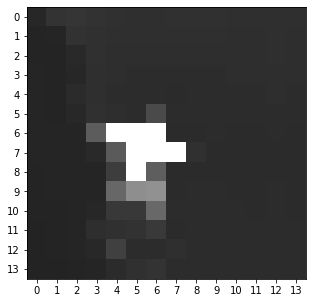

In [571]:
# 모든 word 와 head 의 평균 attention.

attention = attentionMap.mean(0).mean(0)
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
ax.pcolor(attention, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

ax.patch.set_facecolor('black')
ax.set_yticks(np.arange(attention.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(attention.shape[1])+0.5, minor=False)
ax.invert_yaxis()
ax.set_xticklabels(range(14), minor=False)
ax.set_yticklabels(range(14), minor=False)

plt.show()

<start>


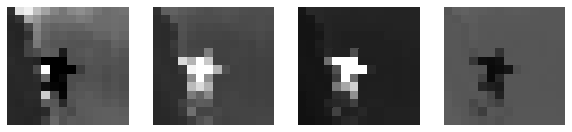

the


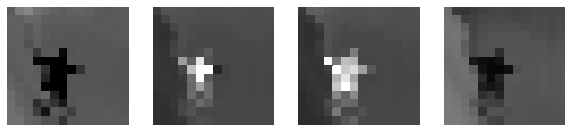

person


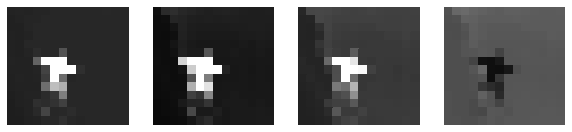

is


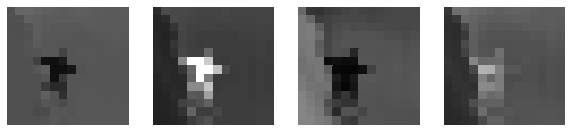

<unk>


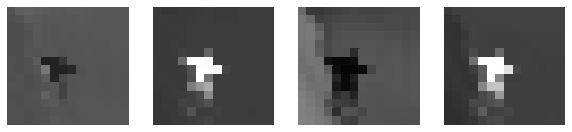

skiing


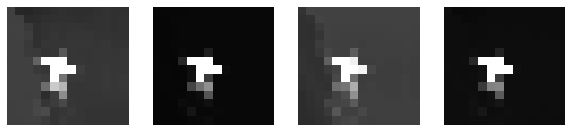

through


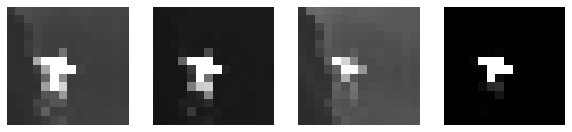

the


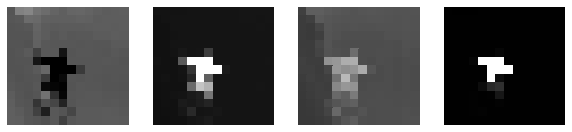

mountains


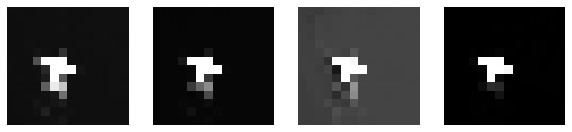

.


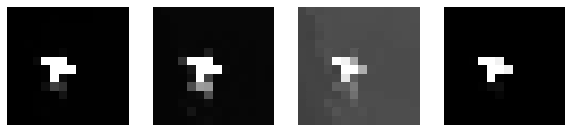

<end>


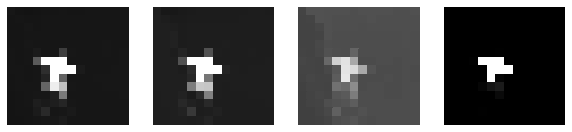

In [572]:
# caption 및 head 마다의 attention.

for i, idx in enumerate(sample.squeeze()):
  if vocab.idx2word[idx.item()] == '<pad>':
    break
  print(vocab.idx2word[idx.item()])

  fig = plt.figure(figsize=(10, 10))
  for j in range(nhead):
    attention = attentionMap[i][j]

    ax = fig.add_subplot(nhead, nhead, j+1)
    ax.pcolor(attention, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(range(14), minor=False)
    ax.set_yticklabels(range(14), minor=False)
    ax.axis('off')

  plt.show()